In [2]:
import pandas as pd
import numpy as np
import os
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
import csv
import statsmodels.formula.api as smf
import pickle

In [109]:
 # Load in trained vectors and vocab count that has word tokens as keys and their count as values
def load_vectors_and_vocab(vectors_path, vocab_path):
    vectors = KeyedVectors.load(vectors_path)
    vocab_count = pickle.load( open( vocab_path, "rb" ) )
    return vectors, vocab_count 

def read_from_txt(filename):
    result = []
    with open(filename, 'r') as file:
        for line in file:
            result.append(line.strip())
    return result

data_path = "cscareerquestions.corpus/"
man_words =  ['man', 'he', 'him', 'hes', 'his', 'himself', 'boy', 'male', 'men', 'boys', 'males']
woman_words = ['woman', 'she', 'shes', 'her', 'hers', 'herself', 'girl', 'female', 'women','girls', 'females']
combined = man_words + woman_words
adjectives_list = set(read_from_txt('adjectives_garg.txt') + read_from_txt('adjectives_princeton.txt'))
personal_list = ['qualified', 'under qualified', 'unqualified']
competence_adjectives = read_from_txt('adjectives_intelligencegeneral.txt')
vocab = read_from_txt(os.path.join(data_path, 'RedditVocab.txt'))
vectors, vocab_count = load_vectors_and_vocab('cscareerquestions.corpus/trainedVectors.wv', "vocab_count.pkl")
all_words = combined + list(adjectives_list) + competence_adjectives + ["indian", "american", "chinese", "mexican"] + ["black", "african american", "white", "caucasian", "asian", "latino", "hispanic"]
all_words = set(all_words)

321


In [112]:
print(competence_adjectives)

['precocious', 'resourceful', 'inquisitive', 'sagacious', 'inventive', 'astute', 'adaptable', 'reflective', 'discerning', 'intuitive', 'inquiring', 'judicious', 'analytical', 'luminous', 'venerable', 'imaginative', 'shrewd', 'thoughtful', 'sage', 'smart', 'ingenious', 'clever', 'brilliant', 'logical', 'intelligent', 'apt', 'genius', 'wise']


In [110]:
with open('all_words_list.pkl', 'wb') as fp:
    pickle.dump(all_words, fp)

In [57]:
def calculate_scores_binary(group_vector_1, group_vector_2, neutral_vector, vocab_count):
    scores = {}
    for word in neutral_vector:
        if vocab_count[word] > 200:
            gv_1_avg = np.mean(vectors.distances(word, group_vector_1))
            gv_2_avg = np.mean(vectors.distances(word, group_vector_2))
            scores[word] = [gv_1_avg, gv_2_avg, gv_1_avg - gv_2_avg, vocab_count[word]]
    return scores

def n_similarity_comp(group_lists, neutral_words):
    neutral_words_filtered = [w for w in neutral_words if vocab_count[w] > 200]
    result = []
    for group_list in group_lists:
        sim = vectors.n_similarity(neutral_words_filtered, group_list)
        print(group_list[0], "similarity: ", sim )
        result.append([group_list[0], sim])
    return pd.DataFrame(result,
                       columns = ["group", "similarity"]).sort_values(by=["similarity"])


## Competence Adjectives Similarity with each different subgroups

We take a list of adjectives that describe competence (taken from garg et al (2018)) and compture the similarity between the list of competence adjectives and lists corresponding to different demographic groups.

In [42]:
competence_ethnicity_sim_df = n_similarity_comp([["black", "african american"], ["white", "caucasian"], ["asian"],
                                                ["latino", "hispanic"]], competence_adjectives)

black similarity:  0.37054795
white similarity:  0.43030035
asian similarity:  0.3809257
latino similarity:  0.34390327


In [44]:
competence_nationality_sim_df = n_similarity_comp([["indian"], ["american"], ["chinese"], ["mexican"]], competence_adjectives)

indian similarity:  0.2803402
american similarity:  0.36643845
chinese similarity:  0.32325757
mexican similarity:  0.29896948


In [62]:
competence_gender_sim_df = n_similarity_comp([man_words, woman_words], competence_adjectives)

man similarity:  0.5231689
woman similarity:  0.44216868


<AxesSubplot:title={'center':'Similarity score between ethnic/racial groups and competence adjectives'}, xlabel='group', ylabel='n_similarity score'>

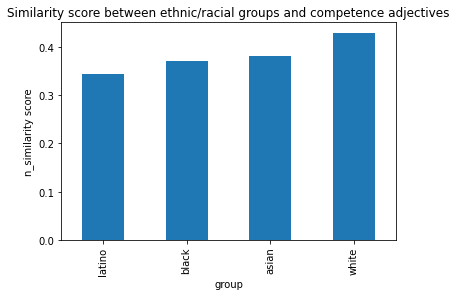

In [53]:
competence_ethnicity_sim_df.plot(x = "group", y = "similarity", kind='bar',ylabel="n_similarity score", 
                                 legend=False, title = "Similarity score between ethnic/racial groups and competence adjectives")

<AxesSubplot:title={'center':'Similarity score between nationality groups and competence adjectives'}, xlabel='group', ylabel='n_similarity score'>

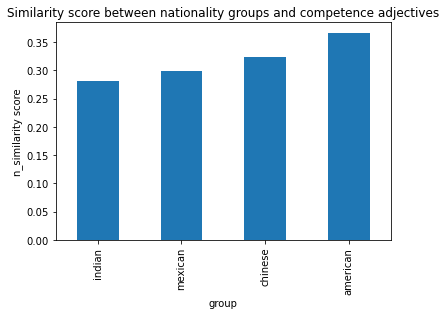

In [55]:
competence_nationality_sim_df.plot(x = "group", y = "similarity", kind='bar', ylabel="n_similarity score", 
                                   legend=False,  title = "Similarity score between nationality groups and competence adjectives")

<AxesSubplot:title={'center':'Similarity score between gender groups and competence adjectives'}, xlabel='group', ylabel='n_similarity score'>

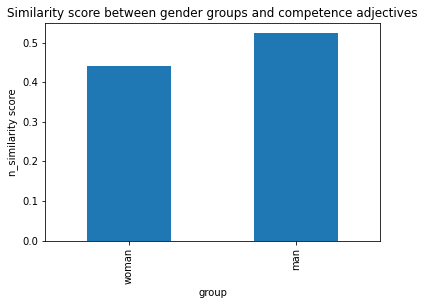

In [63]:
competence_gender_sim_df.plot(x = "group", y = "similarity", kind='bar', ylabel="n_similarity score", 
                                   legend=False,  title = "Similarity score between gender groups and competence adjectives")

## Qualitative analysis looking at which words are most associated with each group

Small note: above we were dealing with similarity so a higher value means the vectors are closer together. Here we are dealing with distance, so lower numbers mean closer together.

In [92]:
woman_man_competence = calculate_scores_binary(woman_words, man_words, competence_adjectives, vocab_count)
woman_man_adjectives = calculate_scores_binary(woman_words, man_words, adjectives_list, vocab_count)


In [93]:
pd.DataFrame.from_dict(woman_man_competence, orient='index', 
                       columns = ["woman", "man", "differences", "count"]).sort_values(by=["differences"])

,woman,man,differences,count
analytical,0.774786,0.820419,-0.045633,632
logical,0.770491,0.804486,-0.033994,1852
intelligent,0.662874,0.680497,-0.017623,1806
intuitive,0.849713,0.860474,-0.010761,728
thoughtful,0.766519,0.776476,-0.009957,342
wise,0.812067,0.798295,0.013772,6376
reflective,0.784770,0.753545,0.031225,288
smart,0.699999,0.664104,0.035895,12438
brilliant,0.702289,0.663380,0.038909,1734
genius,0.686439,0.635412,0.051027,1689


Hard to draw lots of conclusions, but notice that men are more closer to words that are like "elon musk types" vs women are more like hard workers. Their competence is described in different ways.

In [117]:
woman_man_adjectives_df = pd.DataFrame.from_dict(woman_man_adjectives, orient='index', 
                       columns = ["woman", "man", "differences", "count"]).sort_values(by=["differences"])
print(woman_man_adjectives_df.shape)
print(woman_man_adjectives_df.head(10))
print(woman_man_adjectives_df.tail(10))

(140, 4)
                 woman       man  differences  count
outgoing      0.572297  0.668435    -0.096138    336
artistic      0.692267  0.784679    -0.092412    310
natural       0.710444  0.783501    -0.073057   2452
shy           0.619530  0.686455    -0.066925    937
passionate    0.655552  0.722422    -0.066870   7745
attractive    0.727565  0.792345    -0.064780   2470
enthusiastic  0.603383  0.666267    -0.062884   1174
formal        0.773732  0.835927    -0.062195   4766
anxious       0.664430  0.726592    -0.062162   1572
sociable      0.607388  0.664899    -0.057510    302
               woman       man  differences  count
slow        0.857880  0.810188     0.047692   6739
calm        0.704353  0.654876     0.049477   1194
dirty       0.801085  0.748832     0.052253    907
clever      0.811014  0.758709     0.052305   1057
idealistic  0.711010  0.658417     0.052594    204
cynical     0.698745  0.643116     0.055629    479
greedy      0.821401  0.754221     0.067180    858


Not sure what the takeaway is here. Seems like women are often described in terms of their sociability.

## Valence, Arousan, Dominance Analysis

In [82]:
def read_NRC_lexicon(vocab_count):
    vad_lines = []
    with open("NRC-VAD-Lexicon-Aug2018Release/NRC-VAD-Lexicon.txt", 'r') as file:
        for i, line in enumerate(file):
            splitted = line.strip().split('\t')
            if i == 0:
#                 splitted.append('count')
                vad_lines.append(splitted)
            else:
                word = splitted[0]
                count = vocab_count[word]
                if count > 200:
#                     splitted.append(count)
                    vad_lines.append(splitted)
    return vad_lines[1:], vad_lines[0]

vad_lines, cols = read_NRC_lexicon(vocab_count)
vad_df = pd.DataFrame(vad_lines, columns=cols).set_index('Word')
vad_df = vad_df.apply(pd.to_numeric)


In [101]:
gender_adjectives_vad_df = vad_df.merge(woman_man_adjectives_df, right_index=True, left_on='Word')

In [102]:
gender_adjectives_vad_df

,Valence,Arousal,Dominance,woman,man,differences,count
Word,,,,,,,
active,0.847,0.730,0.731,0.819154,0.860454,-0.041300,3741
aggressive,0.125,0.949,0.648,0.723188,0.718826,0.004362,1325
alert,0.479,0.820,0.648,0.786735,0.801628,-0.014893,434
ambitious,0.484,0.821,0.717,0.721730,0.695682,0.026049,1484
anxious,0.281,0.875,0.434,0.664430,0.726592,-0.062162,1572
...,...,...,...,...,...,...,...
warm,0.760,0.312,0.585,0.836986,0.821485,0.015500,904
wary,0.510,0.343,0.535,0.802537,0.827867,-0.025330,1238
weak,0.180,0.241,0.045,0.794459,0.797752,-0.003294,3344


In [120]:
gender_adjectives_vad_regression = smf.ols("""differences ~ Valence + Arousal + Dominance""", data=gender_adjectives_vad_df).fit()
print(gender_adjectives_vad_regression.summary())


                            OLS Regression Results                            
Dep. Variable:            differences   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     4.709
Date:                Fri, 04 Jun 2021   Prob (F-statistic):            0.00371
Time:                        09:51:30   Log-Likelihood:                 274.97
No. Observations:                 137   AIC:                            -541.9
Df Residuals:                     133   BIC:                            -530.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0342      0.011      3.154      0.0

So it seems that valence and arousal are more associated with women than dominance (though dominance is p=.09 so slightly above "significance").

In [124]:
gender_adjectives_vad_regression_joint = smf.ols("""differences ~ Valence * Arousal * Dominance""", data=gender_adjectives_vad_df).fit()
print(gender_adjectives_vad_regression_joint.summary())

                            OLS Regression Results                            
Dep. Variable:            differences   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     2.644
Date:                Fri, 04 Jun 2021   Prob (F-statistic):             0.0138
Time:                        09:52:39   Log-Likelihood:                 277.24
No. Observations:                 137   AIC:                            -538.5
Df Residuals:                     129   BIC:                            -515.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

#### 